In [1]:
import pandas as pd
import numpy as np
import itertools

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import learning_curve, validation_curve, train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import loguniform, beta, uniform

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as IMBPipeline

import missingno as msno

import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')


In [2]:
X, y = fetch_openml(
    'titanic',
    version=1,
    as_frame=True,
    return_X_y=True
) # Load Titanic Dataset
y = y.map({'0':0,'1':1})

In [3]:
# 1. Preprocessing

class AloneTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        idx = X.sum(axis=1) > 1
        X = np.ones(X.shape[0])
        X[idx] = 0
        return X.reshape(-1,1)

    def get_feature_names_out(self, input_features=None):
        return ['is_alone']

def get_title(X):
    return X.squeeze().str.split(", ", expand=True)[1].str.split(".", expand=True)[0].values.reshape(-1,1)

class TitleExtractor(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return get_title(X)

    def get_feature_names_out(self, input_features=None):
        return ['title']


pipeline_age_fare = Pipeline([
    ('imp', KNNImputer(n_neighbors=5) ),
    ('scaler', StandardScaler() )
])

pipeline_sex_embarked = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('hot', OneHotEncoder(categories='auto',drop='first',handle_unknown='ignore'))
])

pipeline_name = Pipeline([
    ('custom', TitleExtractor()),
    ('hot', OneHotEncoder(categories='auto',drop='first',handle_unknown='ignore'))
])

final_transformation = ColumnTransformer(transformers=[
    ('age_fare', pipeline_age_fare ,['age','fare'] ),
    ('pclass', OrdinalEncoder(categories=[[1.0,2.0,3.0]]) ,['pclass'] ),
    ('sex_embarked', pipeline_sex_embarked, ['sex','embarked'] ),
    ('alone', AloneTransformer() , ['sibsp','parch']),
    ('title', pipeline_name, ['name'] )
],
remainder='drop',
verbose_feature_names_out=False,
sparse_threshold=0 #return dense matrix
)

# Note that we are not applying the transformer yet!!

In [4]:
# 2. Train and Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=30, shuffle=True)

In [5]:
# 3. Build the entire pipeline

model_pipeline = IMBPipeline([
    ('trans', final_transformation),
    ('sampler', SMOTE()),
    ('dim_reduction', PCA(n_components=0.8)),
    ('classifier', Perceptron()) # Algoritmo di Apprendimento
])

"""
Teoricamente, è parte della Pipeline anche la Trasformazione.
Posso portarla fuori se voglio ottimizzarla, dato che l'esito
è sempre quello - ma devo ricordarmi di eseguirla con
final_transformation.fit_transform(X_train)
"""

"\nTeoricamente, è parte della Pipeline anche la Trasformazione.\nPosso portarla fuori se voglio ottimizzarla, dato che l'esito\nè sempre quello - ma devo ricordarmi di eseguirla con\nfinal_transformation.fit_transform(X_train)\n"

In [ ]:
# 4. Model Selection

"""
A questo punto tocca capire quale siano gli Hyper-parametri
più adeguati.
Usiamo l'approccio Cross-Validation.
> Il suo obiettivo è prevenire Overfitting (performance
pessime nel test ma buone nel training) e Underfitting (performance
pessime anche sul train set)

L'idea è di splittare ulteriormente il Training Set in Training Set e
Validation Set.
Il Validation Set serve a valutare gli iper parametri scelti
durante il training, ovvero le diverse configurazioni per il modello.

Ad esempio, potrei avere 100mila configurazioni per il modello
> Li addestro tutti sul Training Set
> Li valido tutti sul Validation Set
> Tengo solo quelli che non Underfittano e non Overfittano. Su questi faccio il Training sull'intero Train+Validation Set.
> Poi li testo tutti sul Test Set e prendo il migliore

Esistono approcci più complicati, ad esempio testando su diversi split
la configurazione e scegliendo quello che performa meglio MEDIAMENTE.

CROSS VALIDATION CON K-FOLD
- Divido il Training Set in k insiemi disgiunti, più o meno di uguale
  dimensione (si chiamano FOLD). Prima di farlo mischio i dati per
  forzare l'ipotesi IID.
- Uso k-1 fold come reale Training Set e il rimanente 1 per Validation
  Set.
- Addestro un modello per ogni split, testandone le prestazioni su
  tale split. Ottengo k valori di performance





"""



In [ ]:
"""
LEARNING E VALIDATION CURVE

Faccio il traning in batch:
- Sul primo batch misura Accuracy su training e validation set.
  Inizialmente per il training set sarà massima, perché su pochi sample è facile il fitting. Viceversa vale per il validation set.
- Aumento il numero di samples (passo un altro batch). Faccio lo stesso.

Un buon bias-variance trade-off fa sì che le curve si stringano sulla desired accuracy.


Questo è un modo per capire Overfitting o Underfitting.

Un modo per risolverli è di cambiare i parametri del modello (ridurre il numero).
"""

In [ ]:
"""
HYPERPARAMETER OPTIMIZATION

Iperparametri -> sono i parametri settati prima del processo di apprendimento: sono
gli attributi dell'algoritmo di apprendimento.
 i.e. LogisticRegression has a bool param "Regularization" (gestisce a complessità del modello durante il training)

Vogliamo generare configurazioni di iperparametri in maniera intelligente, per poi esplorarle una ad una e massimizzare le performance. Dobbiamo necessariamente fare ottimizzazione esaustiva (o approssimazioni di essa) - non esistono algoritmi migliori come invece avviene per i parametri.

Approccio GRID SEARCH: brute-force, provando tutte le configurazioni di parametri possibili.
Occorre specificare quale parametro usa per la performance (F1) e refit=True indica di fare il fit di tutto il dataset sul modello migliore.
[ L'oggetto GridSearchCV è esso stesso un Predictor ]

Approccio RANDOMIZED GRID SEARCH: riduce il numero di configurazioni da testare, quando i parametri hanno tanti valori possibili.
Vengono considerati solo alcuni valori, scelti a caso, esplorando l'iperspazio.
[ Devo specificare un po' di parametri per indicare il criterio di estrazione casuale dei valori dallo spazio dei singoli iperparametri -> uso distribuzioni non uniformi]

... saltiamo SUCCESSIVE HALVING SEARCH ...

"""

In [9]:
"""
Ora creiamo un generatore di configurazioni e recuperiamo il migliore.

I nomi non sono casuali, ma usano la notazione classe__parametro, che python interpreta come classe.parametro


"""

sampler_configs = [
    {
        'sampler':[None],# The element is bypassed
    },
    {
        'sampler':[SMOTE()],
        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
    },
    {
        'sampler':[RandomOverSampler()],
        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
    }
]

dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.5, 0.7, 0.9]
    },
    {
        'dim_reduction': [LDA()]
    },
    {
        'dim_reduction': [SFS(estimator=Perceptron(), cv = None, scoring = 'f1')],
        'dim_reduction__estimator': [Perceptron(), LogisticRegression()],
        'dim_reduction__k_features' : [5,7,10]
    }
]

classifier_configs = [
    {
        'classifier__eta0' : loguniform(0.001,100), # Valori per Hyperparam eta0
        'classifier': [Perceptron()] , # Il classificatore
        'classifier__max_iter': [1,5,10,15,50,100] ,# Valori per Hyperparam max_iter
        'classifier__class_weight' : [None, 'balanced']# Valori per Hyperparam class_weight
    },
    {
        'classifier': [LogisticRegression(solver='saga')],
        'classifier__C' : loguniform(0.001,100),
        'classifier__penalty': ['l1','l2'],
        'classifier__class_weight' : [None, 'balanced']
    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3,5,7,9]
    },
    {
        'classifier' : [RandomForestClassifier()],
        'classifier__n_estimators' : [10,50,100, 500]
    }
]

# Genero in maniera automatica tutte le possibilità, che poi passo alla Grid Search CV

all_configs = [
    dict(itertools.chain(*(e.items() for e in configuration)))
    for configuration in itertools.product(
        sampler_configs,
        dim_reduction_configs,
        classifier_configs
    )
]

# Sono 48 algoritmi per generare gli iperparametri, non solo 48 configurazioni di iperparametri
# => È quel che serve alla RandomizedSearchCV!
f'Number of all possible configurations: {len(all_configs)}'

'Number of all possible configurations: 48'

In [13]:
"""
Facciamo poi NESTED CROSS-VALIDATION:
- Otteniamo un insieme limitato di migliori modelli (i "migliori candidati" per essere il nostro modello)
- Ottimizziamo gli iperparametri per ognuno dei modelli

In pratica:
- CV Esterna per selezionare il miglior modello per una certa partizione Train / Validation
- CV Interna per individuare gli iperparametri di quel modello

"""

# Questo è l'inner loop
rs = RandomizedSearchCV(
    model_pipeline,
    param_distributions=all_configs,
    n_iter=len(all_configs) * 5,
    n_jobs=-1,
    cv = 2,
    scoring='f1'
)

# Questo è l'outer loop
scores = cross_validate(
    rs,
    X_train,
    y_train,
    scoring='f1',
    cv = 5, # Numero di fold
    return_estimator=True,
    verbose=3
)

[CV] END ......................................., score=0.662 total time=  22.0s
[CV] END ......................................., score=0.749 total time=  13.9s
[CV] END ......................................., score=0.722 total time=  16.4s
[CV] END ......................................., score=0.745 total time=  14.4s
[CV] END ......................................., score=0.688 total time=  21.2s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.5min finished


In [14]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

RandomOverSampler(sampling_strategy=0.7)
LinearDiscriminantAnalysis()
LogisticRegression(C=np.float64(0.28285780562577223), class_weight='balanced',
                   solver='saga') {'C': np.float64(0.28285780562577223), 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
0.6625
----------
None
LinearDiscriminantAnalysis()
LogisticRegression(C=np.float64(0.003217841404856521), class_weight='balanced',
                   solver='saga') {'C': np.float64(0.003217841404856521), 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
0.7485380116959064

In [15]:
for estimator in scores['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    f1_train = f1_score(y_train, pred_train, average='macro')
    f1_test = f1_score(y_test, pred_test, average='macro')
    print(f'F1 on training set:{f1_train}, F1 on test set:{f1_test}')

F1 on training set:0.7894447269167433, F1 on test set:0.7511642156862746
F1 on training set:0.7883690320401073, F1 on test set:0.7484570017830201
F1 on training set:0.800659125064632, F1 on test set:0.7744313823708968
F1 on training set:0.7975226791476859, F1 on test set:0.7889599620942904
F1 on training set:0.83563579277865, F1 on test set:0.7716339169661288


In [20]:
"""
Alla fine, scelgo a mano il modello ch preferisco ed, eventualmente, ottimizzo ulteriormente gli iperparametri di quel modello.
"""

best_model_pipeline = IMBPipeline([
    ('trans', final_transformation),
    ('classifier',LogisticRegression(solver='saga', penalty = 'l1'))
])

params = {
    'classifier__C': uniform(loc = 5, scale = 60)
}

rs_best = RandomizedSearchCV(
    estimator = best_model_pipeline,
    param_distributions = params,
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3),
    n_iter=20,
    scoring='f1'
)

In [21]:
rs_best.fit(X_train, y_train)

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=None),
                   estimator=Pipeline(steps=[('trans',
                                              ColumnTransformer(sparse_threshold=0,
                                                                transformers=[('age_fare',
                                                                               Pipeline(steps=[('imp',
                                                                                                KNNImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['age',
                                                                                'fare']),
                                                                              ('pclass',
                                                                               OrdinalEncoder(categories=[[1.0,
                                                                                                           2.0,
                                                                                                           3.0]]),
                                                                               ['pclass']),
                                                                              ('sex_embarked',...
                                                                               Pipeline(steps=[('custom',
                                                                                                TitleExtractor()),
                                                                                               ('hot',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['name'])],
                                                                verbose_feature_names_out=False)),
                                             ('classifier',
                                              LogisticRegression(penalty='l1',
                                                                 solver='saga'))]),
                   n_iter=20,
                   param_distributions={'classifier__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000020EE82E17F0>},
                   scoring='f1')

In [22]:
f1_score(y_test, rs_best.best_estimator_.predict(X_test))

0.7419354838709677

In [24]:
rs_best.best_estimator_ #C = 10 circa

Pipeline(steps=[('trans',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('age_fare',
                                                  Pipeline(steps=[('imp',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fare']),
                                                 ('pclass',
                                                  OrdinalEncoder(categories=[[1.0,
                                                                              2.0,
                                                                              3.0]]),
                                                  ['pclass']),
                                                 ('sex_embarked',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('hot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['sex', 'embarked']),
                                                 ('alone', AloneTransformer(),
                                                  ['sibsp', 'parch']),
                                                 ('title',
                                                  Pipeline(steps=[('custom',
                                                                   TitleExtractor()),
                                                                  ('hot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['name'])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 LogisticRegression(C=np.float64(10.084139234037906),
                                    penalty='l1', solver='saga'))])

In [27]:
cls = rs_best.best_estimator_

train_sizes, train_scores, test_scores = learning_curve(
    cls,
    X=X_train,
    y=y_train,
    train_sizes= [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    cv = 5,
    n_jobs = -1,
    scoring = 'f1',
    shuffle = False
)

(0.6, 1.03)

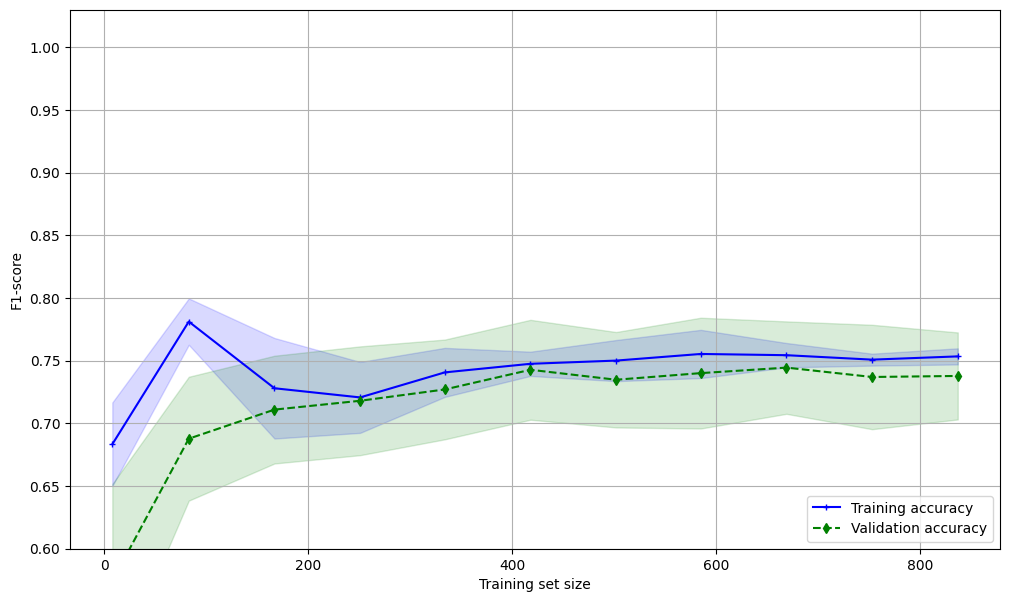

In [28]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()

ax.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training accuracy')

ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=5,
         label='Validation accuracy')

ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Training set size')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.60, 1.03])

In [ ]:
# Esiste anche una validation curve, che plotta al variare di un iperparametro...